In [25]:
import numpy as np
import random
import pandas as pd
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

random.seed(24)
np.random.seed(24)
seed = 24
batch_size = 512
device = 'cuda' if torch.cuda.is_available() else 'cpu'

data_path = '../data/census-income/'

# 整理数据

In [2]:
# 获取特征名称
# !cat census-income.names | grep -E '#' | grep -aE '#[0-9]* \(.*' -o > ./census-income-cols-details

In [3]:
# cols_file = open(data_path + 'census-income-cols-details')
# cols = cols_file.read()
# cols_file.close()
# cols = cols.split('\n')

# cols_types, cols_name = [], []
# for c in cols:
#     cols_types.append(c.split(' ')[-1])
#     cols_name.append('_'.join(c.split(' ')[1:-1]).replace('(','').replace(')',''))

# cols_types=cols_types[0:-1]
# cols_name[-1]='income5k'

In [5]:
def to_categorical(y, num_classes=None, dtype='float32'):
    y = np.array(y, dtype='int')
    input_shape = y.shape
    if input_shape and input_shape[-1]==1 and len(input_shape)>1:
        input_shape = tuple(input_shape[:-1])
    y = y.ravel() # https://numpy.org/doc/stable/reference/generated/numpy.ravel.html
    if not num_classes:
        num_classes = np.max(y) + 1
    n = y.shape[0]
    categorical = np.zeros((n, num_classes), dtype=dtype)
    categorical[np.arange(n), y] = 1
    output_shape = input_shape + (num_classes, )
    categorical = np.reshape(categorical, output_shape)
    return categorical

In [6]:
cols_name = ['age', 'class_worker', 'det_ind_code', 'det_occ_code', 'education', 'wage_per_hour', 'hs_college',
            'marital_stat', 'major_ind_code', 'major_occ_code', 'race', 'hisp_origin', 'sex', 'union_member',
            'unemp_reason', 'full_or_part_emp', 'capital_gains', 'capital_losses', 'stock_dividends',
            'tax_filer_stat', 'region_prev_res', 'state_prev_res', 'det_hh_fam_stat', 'det_hh_summ',
            'instance_weight', 'mig_chg_msa', 'mig_chg_reg', 'mig_move_reg', 'mig_same', 'mig_prev_sunbelt',
            'num_emp', 'fam_under_18', 'country_father', 'country_mother', 'country_self', 'citizenship',
            'own_or_self', 'vet_question', 'vet_benefits', 'weeks_worked', 'year', 'income_50k']

categorical_columns = ['class_worker', 'det_ind_code', 'det_occ_code', 'education', 'hs_college', 'major_ind_code',
                       'major_occ_code', 'race', 'hisp_origin', 'sex', 'union_member', 'unemp_reason',
                       'full_or_part_emp', 'tax_filer_stat', 'region_prev_res', 'state_prev_res', 'det_hh_fam_stat',
                       'det_hh_summ', 'mig_chg_msa', 'mig_chg_reg', 'mig_move_reg', 'mig_same', 'mig_prev_sunbelt',
                       'fam_under_18', 'country_father', 'country_mother', 'country_self', 'citizenship',
                       'vet_question']

In [7]:
def data_pre(cols_name, categorical_columns):
    cols_name = cols_name
    categorical_columns = categorical_columns
    
    train_df = pd.read_csv(data_path + 'census-income.data', names=cols_name)
    test_df = pd.read_csv(data_path + 'census-income.test', names=cols_name)
    label_columns = ['income_50k','marital_stat']
    
    train_transformed = pd.get_dummies(train_df.drop(label_columns, axis=1), 
                                       columns=categorical_columns)
    test_transformed = pd.get_dummies(test_df.drop(label_columns, axis=1),
                                      columns=categorical_columns)
    # 因为dummy变量，train有而test没有，所以单独增加一列
    dummy_lack = list(set(train_transformed.columns)-set(test_transformed.columns))
    # 'det_hh_fam_stat_ Grandchild <18 ever marr not in subfamily'
    for dummy in dummy_lack:
        test_transformed[dummy] = 0
    train_labels = train_df[label_columns]
    test_labels = test_df[label_columns]
    
    # 训练目标的转化
    train_income = to_categorical(
        (train_labels.income_50k == ' 50000+.').astype(int), num_classes=2)
    train_marital = to_categorical(
        (train_labels.marital_stat == ' Never married').astype(int), num_classes=2)
    other_income = to_categorical(
        (test_labels.income_50k == ' 50000+.').astype(int), num_classes=2)
    other_marital = to_categorical(
        (test_labels.marital_stat == ' Never married').astype(int), num_classes=2)
    
    dict_outputs = {'income':train_income.shape[1],'marital':train_marital.shape[1]}
    dict_train_labels = {'income':train_income, 'marital':train_marital}
    dict_other_labels = {'income':other_income, 'marital':other_marital}
    output_info = [(dict_outputs[key], key) for key in sorted(dict_outputs.keys())]
    
    # 再把test数据集0.5分开-依据原文
    validation_indices = test_transformed.sample(
        frac=0.5, replace=False, random_state=seed).index
    test_indices = list(set(test_transformed.index) - set(validation_indices))
    
    # 若干个数据集
    validation_data = test_transformed.iloc[validation_indices]
    validation_label = [dict_other_labels[key][validation_indices] 
                        for key in sorted(dict_other_labels.keys())]
    test_data = test_transformed.iloc[test_indices]
    test_label = [dict_other_labels[key][test_indices] 
                  for key in sorted(dict_other_labels.keys())]
    train_data = train_transformed
    train_label = [dict_train_labels[key] 
                   for key in sorted(dict_train_labels.keys())]
    
    return train_data, train_label, validation_data, validation_label,test_data, test_label, output_info

In [8]:
train_data, train_label, validation_data, validation_label, test_data, test_label, output_info = data_pre(cols_name, categorical_columns)


In [9]:
def getTensorDataset(my_x, my_y):
    tensor_x = torch.Tensor(my_x)
    tensor_y = torch.Tensor(my_y)
    return torch.utils.data.TensorDataset(tensor_x, tensor_y)

In [10]:
train_label_tmp = np.column_stack(
    (np.argmax(train_label[0], axis=1), np.argmax(train_label[1], axis=1)))
train_loader = DataLoader(
    dataset=getTensorDataset(train_data.to_numpy(), train_label_tmp), 
    batch_size=batch_size, shuffle=True)

In [13]:
next(iter(train_loader))[0].size(), next(iter(train_loader))[1].size()

(torch.Size([512, 499]), torch.Size([512, 2]))

# MMOE模型架构定义
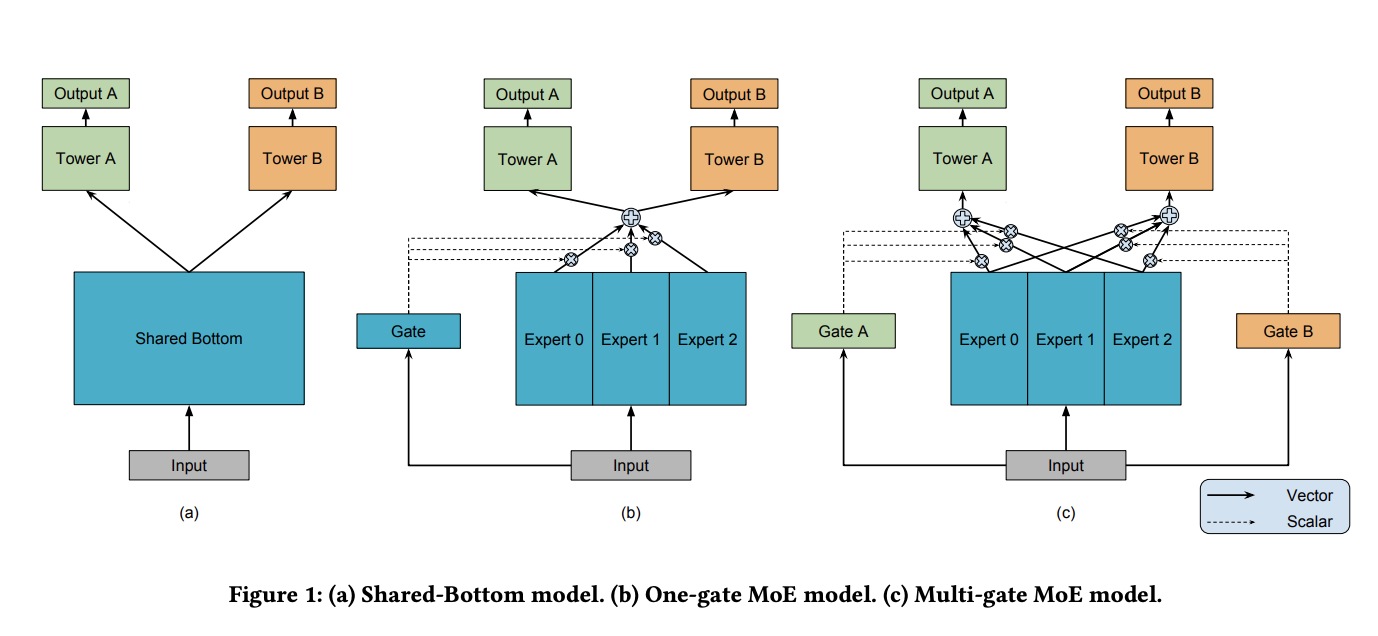
https://dl.acm.org/doi/pdf/10.1145/3219819.3220007

In [14]:
class Expert(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(Expert, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

In [15]:
class Tower(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(Tower, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.4)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

In [16]:
class MMOE(nn.Module):
    def __init__(self, input_size, num_experts, experts_out,
                 experts_hidden, towers_hidden, tasks):
        """
        指定
        """
        super(MMOE, self).__init__()
        self.input_size = input_size
        self.num_experts = num_experts
        self.experts_out = experts_out
        self.experts_hidden = experts_hidden
        self.towers_hidden = towers_hidden
        self.tasks = tasks
        self.softmax = nn.Softmax(dim=1)
        
        self.experts = nn.ModuleList(
            [Expert(self.input_size, self.experts_out, self.experts_hidden) 
            for i in range(self.num_experts)])
        self.w_gates = nn.ParameterList(
            [nn.Parameter(torch.randn(self.input_size, self.num_experts), requires_grad=True)
            for i in range(self.tasks)])
        self.towers = nn.ModuleList(
            [Tower(self.experts_out, 1, self.towers_hidden)
            for i in range(self.tasks)])
    
    def forward(self, x):
        """
        x: 在这里是表格型数据 [batch, input_size]
        """
        experts_o = [e(x) for e in self.experts] 
        # 一个专家输出一个 [batch, experts_out]，拼接为 list
        experts_o_tensor = torch.stack(experts_o) 
        # stack起来 [num_experts, batch, experts_out]
        
        gates_o = [self.softmax(x @ g) for g in self.w_gates]
        # 一个gate输出一个 x @ g, [batch, input_size] @ [input_size, num_experts]
        # 相当于每个gate都给每个专家配备了一个门控，而非一个gate对应一个专家。多对多而非单对单。
        # 几个task就几个gate，所以 [[batch, num_experts], [batch, num_experts]]
        
        tower_input = [g.t().unsqueeze(2).expand(-1,-1,self.experts_out) * experts_o_tensor 
                      for g in gates_o]
        # g: [batch, num_experts]
        # g.t().unsqueeze(2): [num_experts, batch, 1]
        # g.t().unsqueeze(2).expand(-1,-1,self.experts_out): [num_experts, batch, experts_out]
        # experts_o_tensor: [num_experts, batch, experts_out]
        # 直接矩阵点积，获得 2个[num_experts, batch, experts_out] 形成一个list
        
        tower_input = [torch.sum(ti, dim=0) for ti in tower_input]
        # ti: 作为一个专家给的对全部batch的判断 [num_experts, batch, experts_out]
        # torch.sum(ti,dim=0) 之后，得到 2个 [batch, experts_out]
        
        final_output = [t(ti) for t, ti in zip(self.towers, tower_input)]
        # 两个tower（task），ti: [batch, experts_out] 输入t(tower)中，得到 [batch, 1] 共2个
        return final_output

In [17]:
# 测试输入正确
tmp = next(iter(train_loader))[0]

model_tmp = MMOE(input_size=499, num_experts=6, experts_out=16, 
             experts_hidden=32, towers_hidden=8, tasks=2)

tmp_y = model_tmp(tmp)
print(len(tmp_y), tmp_y[0].size())
tmp_y[0][:10]

2 torch.Size([512, 1])


tensor([[0.8900],
        [0.4751],
        [0.4616],
        [0.5594],
        [0.8336],
        [0.4256],
        [0.0013],
        [0.8454],
        [0.9717],
        [0.8283]], grad_fn=<SliceBackward>)

# 获取label数据

In [18]:
train_label_tmp = np.column_stack(
    (np.argmax(train_label[0], axis=1), np.argmax(train_label[1], axis=1)))
train_loader = DataLoader(
    dataset=getTensorDataset(train_data.to_numpy(), train_label_tmp), 
    batch_size=batch_size, shuffle=True)

validation_label_tmp = np.column_stack(
    (np.argmax(validation_label[0], axis=1), np.argmax(validation_label[1], axis=1)))
val_loader = DataLoader(
    dataset=getTensorDataset(validation_data.to_numpy(), validation_label_tmp), 
    batch_size=batch_size)

test_label_tmp = np.column_stack(
    (np.argmax(test_label[0], axis=1), np.argmax(test_label[1], axis=1)))
test_loader = DataLoader(
    dataset=getTensorDataset(test_data.to_numpy(), test_label_tmp), batch_size=batch_size)

In [19]:
print(next(iter(train_loader))[0].size(),
      next(iter(val_loader))[0].size(),
      next(iter(test_loader))[0].size())

torch.Size([512, 499]) torch.Size([512, 499]) torch.Size([512, 499])


# 测试函数

In [20]:
def test(loader):
    t1_pred, t2_pred, t1_target, t2_target = [], [], [], []
    model.eval()
    with torch.no_grad():
        epoch_loss = []
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            yhat = model(x)
            y1, y2 = y[:, 0],y[:, 1]
            yhat_1, yhat_2 = yhat[0], yhat[1]

            loss1, loss2 = loss_fn(yhat_1, y1.view(-1, 1)), loss_fn(yhat_2, y2.view(-1, 1))
            loss = loss1 + loss2

            # t1_hat = yhat_1.view(-1) > 0.7
            # t2_hat = yhat_2.view(-1) > 0.5
            t1_hat, t2_hat = list(yhat_1), list(yhat_2)

            t1_pred += t1_hat
            t2_pred += t2_hat
            t1_target += list(y1)
            t2_target += list(y2)
#     return t1_target, t2_target, t1_pred, t2_pred
#     t1_pred = [1 if x else 0 for x in list(t1_pred)]
#     t2_pred = [1 if x else 0 for x in list(t2_pred)]
    
    
    t1_target = [i.item() for i in t1_target]
    t2_target = [i.item() for i in t2_target]
    t1_pred = [i.item() for i in t1_pred]
    t2_pred = [i.item() for i in t2_pred]
    auc_1 = roc_auc_score(t1_target, t1_pred)
    auc_2 = roc_auc_score(t2_target, t2_pred)
    return auc_1, auc_2

# MMOE模型应用

In [36]:
model = MMOE(input_size=499, num_experts=6, experts_out=16, 
             experts_hidden=32, towers_hidden=8, tasks=2)
model = model.to(device)

In [37]:
lr = 1e-4
n_epochs = 100
loss_fn = nn.BCELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
losses = []
val_loss = []

In [38]:
# 测试test函数
auc1,auc2 = test(test_loader)
print('测试test-auc函数: ', auc1,auc2)

测试test-auc函数:  0.37227054556447803 0.5449308542903704


In [39]:
auc1_max, auc2_max = 0, 0 

for epoch in tqdm(range(n_epochs)):
    model.train()
    epoch_loss = []
    c = 0
    print("Epoch: {}/{}".format(epoch, n_epochs))
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        y_hat = model(x)

        y1, y2 = y[:, 0], y[:, 1]
        y_1, y_2 = y_hat[0], y_hat[1]

        loss1 = loss_fn(y_1, y1.view(-1, 1))
        loss2 = loss_fn(y_2, y2.view(-1, 1))
        loss = loss1 + loss2
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epoch_loss.append(loss.item())
    losses.append(np.mean(epoch_loss))

    auc1, auc2 = test(val_loader)
    auc1_max, auc2_max = max(auc1_max, auc1), max(auc2_max, auc2)
    print('train loss: {:.5f}, val task1 auc: {:.5f}, val task2 auc: {:.3f}'.format(
        np.mean(epoch_loss), auc1, auc2))

    if auc1 >= auc1_max and auc2 >= auc2_max:
        torch.save(model.state_dict(), './model-mmoe-v1-save/model'+
                  '_auc1_'+str(round(auc1,4))+
                  '_auc2_'+str(round(auc2,4)))

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0/100


  1%|          | 1/100 [00:14<24:27, 14.82s/it]

train loss: 2.64831, val task1 auc: 0.67110, val task2 auc: 0.575
Epoch: 1/100


  2%|▏         | 2/100 [00:30<24:39, 15.09s/it]

train loss: 1.05945, val task1 auc: 0.68584, val task2 auc: 0.895
Epoch: 2/100


  3%|▎         | 3/100 [00:44<23:44, 14.69s/it]

train loss: 0.87511, val task1 auc: 0.69327, val task2 auc: 0.928
Epoch: 3/100


  4%|▍         | 4/100 [00:58<23:23, 14.62s/it]

train loss: 0.74794, val task1 auc: 0.70356, val task2 auc: 0.943
Epoch: 4/100


  5%|▌         | 5/100 [01:13<23:09, 14.63s/it]

train loss: 0.67697, val task1 auc: 0.71803, val task2 auc: 0.948
Epoch: 5/100


  6%|▌         | 6/100 [01:26<22:18, 14.24s/it]

train loss: 0.61514, val task1 auc: 0.73820, val task2 auc: 0.951
Epoch: 6/100


  7%|▋         | 7/100 [01:43<23:18, 15.04s/it]

train loss: 0.55847, val task1 auc: 0.77315, val task2 auc: 0.953
Epoch: 7/100


  8%|▊         | 8/100 [02:00<23:47, 15.52s/it]

train loss: 0.52169, val task1 auc: 0.82497, val task2 auc: 0.957
Epoch: 8/100


  9%|▉         | 9/100 [02:15<23:21, 15.40s/it]

train loss: 0.49128, val task1 auc: 0.86540, val task2 auc: 0.959
Epoch: 9/100


 10%|█         | 10/100 [02:28<22:13, 14.81s/it]

train loss: 0.46727, val task1 auc: 0.88472, val task2 auc: 0.963
Epoch: 10/100


 11%|█         | 11/100 [02:41<21:10, 14.28s/it]

train loss: 0.44203, val task1 auc: 0.90236, val task2 auc: 0.967
Epoch: 11/100


 12%|█▏        | 12/100 [02:56<21:05, 14.38s/it]

train loss: 0.41790, val task1 auc: 0.90695, val task2 auc: 0.970
Epoch: 12/100


 13%|█▎        | 13/100 [03:13<21:53, 15.10s/it]

train loss: 0.39724, val task1 auc: 0.91118, val task2 auc: 0.974
Epoch: 13/100


 14%|█▍        | 14/100 [03:27<21:16, 14.84s/it]

train loss: 0.38374, val task1 auc: 0.91262, val task2 auc: 0.975
Epoch: 14/100


 15%|█▌        | 15/100 [03:40<20:26, 14.42s/it]

train loss: 0.37415, val task1 auc: 0.91555, val task2 auc: 0.977
Epoch: 15/100


 16%|█▌        | 16/100 [03:55<20:14, 14.46s/it]

train loss: 0.36848, val task1 auc: 0.91832, val task2 auc: 0.979
Epoch: 16/100


 17%|█▋        | 17/100 [04:09<19:51, 14.36s/it]

train loss: 0.36078, val task1 auc: 0.91996, val task2 auc: 0.979
Epoch: 17/100


 18%|█▊        | 18/100 [04:24<19:58, 14.62s/it]

train loss: 0.35658, val task1 auc: 0.92058, val task2 auc: 0.979
Epoch: 18/100


 19%|█▉        | 19/100 [04:38<19:24, 14.37s/it]

train loss: 0.35332, val task1 auc: 0.92268, val task2 auc: 0.980
Epoch: 19/100


 20%|██        | 20/100 [04:52<18:56, 14.21s/it]

train loss: 0.34502, val task1 auc: 0.92391, val task2 auc: 0.979
Epoch: 20/100


 21%|██        | 21/100 [05:06<18:36, 14.13s/it]

train loss: 0.33858, val task1 auc: 0.92517, val task2 auc: 0.980
Epoch: 21/100


 22%|██▏       | 22/100 [05:20<18:24, 14.16s/it]

train loss: 0.33707, val task1 auc: 0.92608, val task2 auc: 0.980
Epoch: 22/100


 23%|██▎       | 23/100 [05:34<18:06, 14.11s/it]

train loss: 0.33303, val task1 auc: 0.92649, val task2 auc: 0.978
Epoch: 23/100


 24%|██▍       | 24/100 [05:47<17:30, 13.82s/it]

train loss: 0.32952, val task1 auc: 0.92865, val task2 auc: 0.978
Epoch: 24/100


 25%|██▌       | 25/100 [06:02<17:30, 14.00s/it]

train loss: 0.32942, val task1 auc: 0.92898, val task2 auc: 0.979
Epoch: 25/100


 26%|██▌       | 26/100 [06:15<16:53, 13.69s/it]

train loss: 0.32755, val task1 auc: 0.92979, val task2 auc: 0.977
Epoch: 26/100


 27%|██▋       | 27/100 [06:28<16:24, 13.49s/it]

train loss: 0.32068, val task1 auc: 0.92921, val task2 auc: 0.977
Epoch: 27/100


 28%|██▊       | 28/100 [06:40<15:54, 13.25s/it]

train loss: 0.31653, val task1 auc: 0.93117, val task2 auc: 0.976
Epoch: 28/100


 29%|██▉       | 29/100 [06:53<15:33, 13.15s/it]

train loss: 0.31501, val task1 auc: 0.93154, val task2 auc: 0.976
Epoch: 29/100


 30%|███       | 30/100 [07:06<15:15, 13.08s/it]

train loss: 0.31276, val task1 auc: 0.93340, val task2 auc: 0.977
Epoch: 30/100


 31%|███       | 31/100 [07:21<15:33, 13.53s/it]

train loss: 0.30975, val task1 auc: 0.93280, val task2 auc: 0.979
Epoch: 31/100


 32%|███▏      | 32/100 [07:37<16:07, 14.23s/it]

train loss: 0.30727, val task1 auc: 0.93398, val task2 auc: 0.975
Epoch: 32/100


 33%|███▎      | 33/100 [07:52<16:10, 14.49s/it]

train loss: 0.30587, val task1 auc: 0.93413, val task2 auc: 0.975
Epoch: 33/100


 34%|███▍      | 34/100 [08:07<16:04, 14.61s/it]

train loss: 0.30397, val task1 auc: 0.93467, val task2 auc: 0.975
Epoch: 34/100


 35%|███▌      | 35/100 [08:19<15:14, 14.07s/it]

train loss: 0.30166, val task1 auc: 0.93524, val task2 auc: 0.975
Epoch: 35/100


 36%|███▌      | 36/100 [08:32<14:37, 13.72s/it]

train loss: 0.29966, val task1 auc: 0.93652, val task2 auc: 0.975
Epoch: 36/100


 37%|███▋      | 37/100 [08:45<14:10, 13.49s/it]

train loss: 0.30178, val task1 auc: 0.93624, val task2 auc: 0.971
Epoch: 37/100


 38%|███▊      | 38/100 [08:59<13:58, 13.52s/it]

train loss: 0.29919, val task1 auc: 0.93546, val task2 auc: 0.976
Epoch: 38/100


 39%|███▉      | 39/100 [09:13<13:48, 13.58s/it]

train loss: 0.29418, val task1 auc: 0.93780, val task2 auc: 0.978
Epoch: 39/100


 40%|████      | 40/100 [09:26<13:33, 13.57s/it]

train loss: 0.29273, val task1 auc: 0.93747, val task2 auc: 0.975
Epoch: 40/100


 41%|████      | 41/100 [09:40<13:25, 13.66s/it]

train loss: 0.29233, val task1 auc: 0.93743, val task2 auc: 0.972
Epoch: 41/100


 42%|████▏     | 42/100 [09:54<13:09, 13.61s/it]

train loss: 0.28989, val task1 auc: 0.93664, val task2 auc: 0.971
Epoch: 42/100


 43%|████▎     | 43/100 [10:09<13:22, 14.07s/it]

train loss: 0.29156, val task1 auc: 0.93761, val task2 auc: 0.969
Epoch: 43/100


 44%|████▍     | 44/100 [10:22<13:03, 13.98s/it]

train loss: 0.28879, val task1 auc: 0.93751, val task2 auc: 0.972
Epoch: 44/100


 45%|████▌     | 45/100 [10:36<12:38, 13.80s/it]

train loss: 0.28678, val task1 auc: 0.93948, val task2 auc: 0.969
Epoch: 45/100


 46%|████▌     | 46/100 [10:50<12:37, 14.02s/it]

train loss: 0.28529, val task1 auc: 0.93901, val task2 auc: 0.972
Epoch: 46/100


 47%|████▋     | 47/100 [11:03<12:02, 13.64s/it]

train loss: 0.28633, val task1 auc: 0.93846, val task2 auc: 0.967
Epoch: 47/100


 48%|████▊     | 48/100 [11:17<11:53, 13.73s/it]

train loss: 0.28234, val task1 auc: 0.93915, val task2 auc: 0.971
Epoch: 48/100


 49%|████▉     | 49/100 [11:31<11:43, 13.80s/it]

train loss: 0.28221, val task1 auc: 0.93929, val task2 auc: 0.974
Epoch: 49/100


 50%|█████     | 50/100 [11:44<11:14, 13.49s/it]

train loss: 0.28105, val task1 auc: 0.93960, val task2 auc: 0.972
Epoch: 50/100


 51%|█████     | 51/100 [11:57<11:03, 13.54s/it]

train loss: 0.28154, val task1 auc: 0.94027, val task2 auc: 0.968
Epoch: 51/100


 52%|█████▏    | 52/100 [12:11<10:46, 13.46s/it]

train loss: 0.27975, val task1 auc: 0.93917, val task2 auc: 0.968
Epoch: 52/100


 53%|█████▎    | 53/100 [12:24<10:33, 13.49s/it]

train loss: 0.28143, val task1 auc: 0.94036, val task2 auc: 0.967
Epoch: 53/100


 54%|█████▍    | 54/100 [12:38<10:29, 13.69s/it]

train loss: 0.27842, val task1 auc: 0.94040, val task2 auc: 0.964
Epoch: 54/100


 55%|█████▌    | 55/100 [12:54<10:34, 14.10s/it]

train loss: 0.27731, val task1 auc: 0.93851, val task2 auc: 0.972
Epoch: 55/100


 56%|█████▌    | 56/100 [13:06<10:02, 13.70s/it]

train loss: 0.27689, val task1 auc: 0.94147, val task2 auc: 0.962
Epoch: 56/100


 57%|█████▋    | 57/100 [13:19<09:39, 13.48s/it]

train loss: 0.27781, val task1 auc: 0.94076, val task2 auc: 0.971
Epoch: 57/100


 58%|█████▊    | 58/100 [13:35<09:50, 14.07s/it]

train loss: 0.27573, val task1 auc: 0.94097, val task2 auc: 0.974
Epoch: 58/100


 59%|█████▉    | 59/100 [13:51<09:59, 14.62s/it]

train loss: 0.27613, val task1 auc: 0.93975, val task2 auc: 0.962
Epoch: 59/100


 60%|██████    | 60/100 [14:07<10:07, 15.18s/it]

train loss: 0.27504, val task1 auc: 0.94164, val task2 auc: 0.972
Epoch: 60/100


 61%|██████    | 61/100 [14:22<09:44, 14.99s/it]

train loss: 0.27473, val task1 auc: 0.93951, val task2 auc: 0.972
Epoch: 61/100


 62%|██████▏   | 62/100 [14:37<09:34, 15.11s/it]

train loss: 0.27296, val task1 auc: 0.94163, val task2 auc: 0.973
Epoch: 62/100


 63%|██████▎   | 63/100 [14:51<09:10, 14.89s/it]

train loss: 0.27273, val task1 auc: 0.94087, val task2 auc: 0.970
Epoch: 63/100


 64%|██████▍   | 64/100 [15:07<08:58, 14.96s/it]

train loss: 0.27376, val task1 auc: 0.94170, val task2 auc: 0.964
Epoch: 64/100


 65%|██████▌   | 65/100 [15:22<08:45, 15.01s/it]

train loss: 0.27173, val task1 auc: 0.94180, val task2 auc: 0.973
Epoch: 65/100


 66%|██████▌   | 66/100 [15:37<08:37, 15.21s/it]

train loss: 0.27410, val task1 auc: 0.94175, val task2 auc: 0.973
Epoch: 66/100


 67%|██████▋   | 67/100 [15:51<08:09, 14.82s/it]

train loss: 0.27315, val task1 auc: 0.94251, val task2 auc: 0.974
Epoch: 67/100


 68%|██████▊   | 68/100 [16:05<07:45, 14.56s/it]

train loss: 0.27179, val task1 auc: 0.94143, val task2 auc: 0.970
Epoch: 68/100


 69%|██████▉   | 69/100 [16:20<07:29, 14.49s/it]

train loss: 0.27265, val task1 auc: 0.94267, val task2 auc: 0.974
Epoch: 69/100


 70%|███████   | 70/100 [16:34<07:14, 14.47s/it]

train loss: 0.27070, val task1 auc: 0.94149, val task2 auc: 0.972
Epoch: 70/100


 71%|███████   | 71/100 [16:49<07:08, 14.78s/it]

train loss: 0.27213, val task1 auc: 0.94225, val task2 auc: 0.971
Epoch: 71/100


 72%|███████▏  | 72/100 [17:04<06:51, 14.71s/it]

train loss: 0.26984, val task1 auc: 0.94165, val task2 auc: 0.971
Epoch: 72/100


 73%|███████▎  | 73/100 [17:18<06:35, 14.64s/it]

train loss: 0.27023, val task1 auc: 0.94199, val task2 auc: 0.975
Epoch: 73/100


 74%|███████▍  | 74/100 [17:35<06:37, 15.30s/it]

train loss: 0.27144, val task1 auc: 0.94209, val task2 auc: 0.973
Epoch: 74/100


 75%|███████▌  | 75/100 [17:51<06:23, 15.34s/it]

train loss: 0.26978, val task1 auc: 0.94038, val task2 auc: 0.973
Epoch: 75/100


 76%|███████▌  | 76/100 [18:04<05:56, 14.84s/it]

train loss: 0.26914, val task1 auc: 0.94214, val task2 auc: 0.974
Epoch: 76/100


 77%|███████▋  | 77/100 [18:18<05:30, 14.39s/it]

train loss: 0.27067, val task1 auc: 0.94159, val task2 auc: 0.973
Epoch: 77/100


 78%|███████▊  | 78/100 [18:32<05:16, 14.40s/it]

train loss: 0.26921, val task1 auc: 0.94193, val task2 auc: 0.973
Epoch: 78/100


 79%|███████▉  | 79/100 [18:45<04:55, 14.06s/it]

train loss: 0.26913, val task1 auc: 0.94213, val task2 auc: 0.972
Epoch: 79/100


 80%|████████  | 80/100 [18:58<04:33, 13.65s/it]

train loss: 0.26764, val task1 auc: 0.94213, val task2 auc: 0.971
Epoch: 80/100


 81%|████████  | 81/100 [19:12<04:21, 13.78s/it]

train loss: 0.26867, val task1 auc: 0.94294, val task2 auc: 0.971
Epoch: 81/100


 82%|████████▏ | 82/100 [19:28<04:19, 14.42s/it]

train loss: 0.26733, val task1 auc: 0.94241, val task2 auc: 0.965
Epoch: 82/100


 83%|████████▎ | 83/100 [19:43<04:07, 14.58s/it]

train loss: 0.26731, val task1 auc: 0.93969, val task2 auc: 0.968
Epoch: 83/100


 84%|████████▍ | 84/100 [19:57<03:49, 14.33s/it]

train loss: 0.26867, val task1 auc: 0.94289, val task2 auc: 0.966
Epoch: 84/100


 85%|████████▌ | 85/100 [20:13<03:41, 14.74s/it]

train loss: 0.26749, val task1 auc: 0.94289, val task2 auc: 0.979
Epoch: 85/100


 86%|████████▌ | 86/100 [20:30<03:36, 15.48s/it]

train loss: 0.26752, val task1 auc: 0.94298, val task2 auc: 0.973
Epoch: 86/100


 87%|████████▋ | 87/100 [20:46<03:23, 15.67s/it]

train loss: 0.26856, val task1 auc: 0.94221, val task2 auc: 0.973
Epoch: 87/100


 88%|████████▊ | 88/100 [21:00<03:04, 15.36s/it]

train loss: 0.26694, val task1 auc: 0.94172, val task2 auc: 0.974
Epoch: 88/100


 89%|████████▉ | 89/100 [21:14<02:43, 14.90s/it]

train loss: 0.26565, val task1 auc: 0.94285, val task2 auc: 0.977
Epoch: 89/100


 90%|█████████ | 90/100 [21:28<02:25, 14.58s/it]

train loss: 0.26613, val task1 auc: 0.94352, val task2 auc: 0.975
Epoch: 90/100


 91%|█████████ | 91/100 [21:42<02:08, 14.24s/it]

train loss: 0.26774, val task1 auc: 0.94301, val task2 auc: 0.971
Epoch: 91/100


 92%|█████████▏| 92/100 [21:55<01:51, 13.97s/it]

train loss: 0.26623, val task1 auc: 0.94205, val task2 auc: 0.973
Epoch: 92/100


 93%|█████████▎| 93/100 [22:09<01:38, 14.03s/it]

train loss: 0.26520, val task1 auc: 0.94314, val task2 auc: 0.977
Epoch: 93/100


 94%|█████████▍| 94/100 [22:23<01:23, 13.96s/it]

train loss: 0.26487, val task1 auc: 0.94342, val task2 auc: 0.969
Epoch: 94/100


 95%|█████████▌| 95/100 [22:38<01:11, 14.36s/it]

train loss: 0.26442, val task1 auc: 0.94333, val task2 auc: 0.974
Epoch: 95/100


 96%|█████████▌| 96/100 [22:55<00:59, 15.00s/it]

train loss: 0.26576, val task1 auc: 0.94365, val task2 auc: 0.968
Epoch: 96/100


 97%|█████████▋| 97/100 [23:09<00:44, 14.91s/it]

train loss: 0.26397, val task1 auc: 0.94246, val task2 auc: 0.973
Epoch: 97/100


 98%|█████████▊| 98/100 [23:24<00:29, 14.75s/it]

train loss: 0.26383, val task1 auc: 0.94295, val task2 auc: 0.974
Epoch: 98/100


 99%|█████████▉| 99/100 [23:38<00:14, 14.45s/it]

train loss: 0.26544, val task1 auc: 0.94265, val task2 auc: 0.970
Epoch: 99/100


100%|██████████| 100/100 [23:53<00:00, 14.33s/it]

train loss: 0.26442, val task1 auc: 0.94286, val task2 auc: 0.974


In [42]:
!ls ./model-mmoe-v1-save/

model_auc1_0.6711_auc2_0.5753  model_auc1_0.8847_auc2_0.9631
model_auc1_0.6858_auc2_0.8953  model_auc1_0.9024_auc2_0.9668
model_auc1_0.6933_auc2_0.9282  model_auc1_0.907_auc2_0.9702
model_auc1_0.7036_auc2_0.943   model_auc1_0.9112_auc2_0.9739
model_auc1_0.718_auc2_0.948    model_auc1_0.9126_auc2_0.9752
model_auc1_0.7382_auc2_0.9509  model_auc1_0.9155_auc2_0.9771
model_auc1_0.7732_auc2_0.9534  model_auc1_0.9183_auc2_0.9786
model_auc1_0.825_auc2_0.9567   model_auc1_0.9227_auc2_0.9796
model_auc1_0.8654_auc2_0.9594  model_auc1_0.9252_auc2_0.9799
modelauc10.8846auc20.8246      model_auc1_0.92_auc2_0.979


In [40]:
# model_mmoe_load = MMOE(input_size=499, num_experts=6, experts_out=16, 
#              experts_hidden=32, towers_hidden=8, tasks=2)
# model_mmoe_load.load_state_dict(torch.load('./model-mmoe-v1-save/model_auc1_0.9252_auc2_0.9799'))
# model = model_mmoe_load
auc1, auc2 = test(test_loader)
print('test task1 auc: {:.3f}, test task2 auc: {:.3f}'.format(auc1, auc2))

test task1 auc: 0.946, test task2 auc: 0.974
